In [3]:
import numpy as np
import peakutils


from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate

import pandas as pd
from pyearth import Earth

In [4]:
# load some data
def loaddata(data_filename):
    """load matrix data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[1:,0]    #wavelength in nm
    data_time = data[0,1:]
    data_z = data[1:, 1:]

    return data_nm, data_time, data_z

In [5]:
# add noise
def add_noise(nm_array, y_array, noise_coefficient):
    # Add noise
    np.random.seed(1800)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    y_proc = y_array + y_noise
    
    return y_proc

In [6]:
def Earth_Smoothing(nm_array, y_array,noise_coefficient):        
    """
    ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
    
   # Fit an Earth model
    model = Earth(smooth=True)
    np.random.seed(42)
    ydata = y_array + noise_coefficient*np.random.normal(size=nm_array.size)
    model.fit(nm_array, ydata)

   # Print the model
    #print(model.trace())
    #print(model.summary())

   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
    
    return  y_hat

In [7]:
def earth_smooth_matrix(nm_array,data_matrix,noise_coefficient):
    num_array = np.shape(data_matrix)[0]
    
    smooth_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    noise_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        
        # get noise and smooth list
        noise_array = add_noise(nm_array, data_array, noise_coefficient).tolist()
        smooth_array =earth_Smoothing(nm_array,data_array,noise_coefficient).tolist()
        
        # get noise dataframe
        DF = pd.DataFrame(noise_array,columns = [i])
        noise_matx = noise_matx.join(DF)
        
        # get smooth dataframe
        df = pd.DataFrame(smooth_array,columns = [i])
        smooth_matx = smooth_matx.join(df)
        
    # drop the first columns  
    noise_matx = noise_matx.drop(columns='a')
    smooth_matx = smooth_matx.drop(columns='a')
        
    return noise_matx, smooth_matx

In [8]:
def findpeak(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks"""    
    peak_indices = peakutils.indexes(data_z_array, thres=threshold, min_dist=min_dist)
    
    return peak_indices

In [9]:
def earth_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = Earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak)
    
    return true_df, smooth_df

# Use py-earth to smoothen data and peakutils to find peaks #

In [10]:
matx_filename = 'threegaussian_broadpeak.txt'
datanm, datatime, dataz_matx = loaddata(matx_filename)
## get the peak position dataframe of true data set
true_df, smooth_df = earth_peak_matrix(datanm, dataz_matx, 0.1, 0, 10)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [38]:
from syntheticdata_threegaussian_noshift_broadpeak import gaussian, monoexp, data_matrix

In [41]:
def make_data_matrix(nm_array, time_coeff_array, spectrum):
    """
    generates a two-way data matrix based on a known 
    spectrum and the spectrum's decay
    
    Args:
        nm_array: wavelength array
        time_coeff_array: an array that describes the decay
        spectrum: an array of the spectrum
    
    Returns:
        data_matrix: a matrix that contains the spectrum at each time
    """
    
    data_matrix = np.empty((np.shape(nm_array)[0], np.shape(time_coeff_array)[0]))
    for i in range(np.shape(time_coeff_array)[0]):
        data_matrix[:, i] = time_coeff_array[i] * spectrum
    
    return data_matrix

In [42]:
#create time array  
time = np.arange(0, 5000, 1)

#create wavelength array
nm = np.arange(850, 1600, 1)

a1 = 1
#center and FWHM of the gaussian 
x0_1 = 950
sigma_1 = 30

#life-time of the gaussian
tau1 = 10


#create a second gaussian
a2 = 0.3
x0_2 = 1300
sigma_2 = 100
tau2 = 5000


#create gaussian #3
a3 = 0.2
x0_3 = 1100
sigma_3 = 600
tau3 = 5000


#generate a gaussian model
species_1 = gaussian(nm, a1, x0_1, sigma_1)

#generate an array of time-coefficients 
#describing a mono-exponential decay with a given lifetime 
time_coeff_1 = monoexp(time, tau1)

#generate a data matrix that contains a gaussian model at each
#time and decays mono-exponentially
data_matrix_1 = make_data_matrix(nm, time_coeff_1, species_1)


#generate a second data matrix that contains a gaussian model
#at each time and decays mono-exponentially
species_2 = gaussian(nm, a2, x0_2, sigma_2)
time_coeff_2 = monoexp(time, tau2)
data_matrix_2 = make_data_matrix(nm, time_coeff_2, species_2)


#generate the third data matrix that contains a gaussian model
#at each time and decays mono-exponentially
species_3 = gaussian(nm, a3, x0_3, sigma_3)
time_coeff_3 = monoexp(time, tau3)
data_matrix_3 = make_data_matrix(nm, time_coeff_3, species_3)



#generate a two-gaussian mixture model by adding 
#the two gaussians above
data_matrix_sum = data_matrix_1 + data_matrix_2 + data_matrix_3

In [66]:
def plot_timeslice(nm, time, select_times, data):
    select_times_idx = [find_nearest(time, x) for x in select_times]
    num_times = len(select_times_idx)
    data_timeslice = np.empty((len(nm), num_times))
    
    plt.figure()
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (a.u.)')
    for i in range(num_times):
        data_timeslice_i = data[:, select_times_idx[i]]
        data_timeslice[:, i] = data_timeslice_i
        plt.plot(nm, data_timeslice_i, label = select_times[i])
    plt.legend()
    return data_timeslice

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def get_timeslice(nm, time, select_time, data):
    select_times_idx = find_nearest(time, select_time)
    data_timeslice = data[:, select_times_idx]
    data_timeslice_norm = data_timeslice / np.max(data_timeslice)
    
    return data_timeslice_norm

## Plot time-slices ##

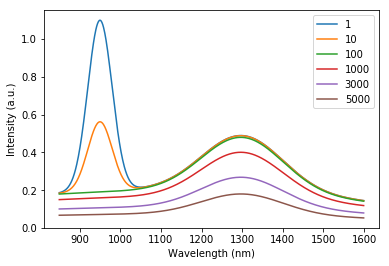

In [56]:
#select time points to plot
times = [1, 10, 100, 1000, 3000, 5000]

#plot 1d time-slice 
timeslice_matx = plot_timeslice(datanm, datatime, times, data_matrix_sum)


## Plot normalized individual spectrum ##

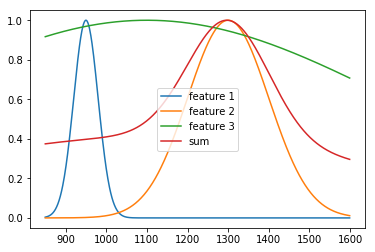

In [67]:
time = 1000
timeslice_matx_1 = get_timeslice(datanm, datatime, time, data_matrix_1)
timeslice_matx_2 = get_timeslice(datanm, datatime, time, data_matrix_2)
timeslice_matx_3 = get_timeslice(datanm, datatime, time, data_matrix_3)
timeslice_matx_sum = get_timeslice(datanm, datatime, time, data_matrix_sum)


plt.figure()
plt.plot(datanm, timeslice_matx_1)
plt.plot(datanm, timeslice_matx_2)
plt.plot(datanm, timeslice_matx_3)
plt.plot(datanm, timeslice_matx_sum)
plt.legend(('feature 1', 'feature 2', 'feature 3', 'sum'))

# Peak-finding doesn't work in this scenario #

In [11]:
true_df

,0,1
0,100,446.0
1,100,446.0
2,100,446.0
3,100,446.0
4,100,446.0
5,100,447.0
6,100,447.0
7,100,446.0
8,100,446.0
9,100,446.0


In [12]:
smooth_df

,0,1,2,3
0,99,419.0,NaN,NaN
1,100,419.0,NaN,NaN
2,103,418.0,NaN,NaN
3,102,421.0,NaN,NaN
4,104,419.0,NaN,NaN
5,106,421.0,NaN,NaN
6,105,425.0,NaN,NaN
7,101,436.0,NaN,NaN
8,103,429.0,NaN,NaN
9,95,428.0,NaN,NaN
